##  Computer Vision Project 
This is a baseline Model 

In [111]:
import torch 
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader


In [112]:
import matplotlib.pyplot as plt

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" The device Being used is:  {device}")

 The device Being used is:  cpu


In [114]:
print("Torch Version", torch.__version__)
print("TorchVision Version", torchvision.__version__)

Torch Version 2.7.0+cpu
TorchVision Version 0.22.0+cpu


In [115]:
# Downloading training and Test dataset of FashionMNIST form torchvision.datasets
train_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    transform=ToTensor(),
    download=True

)

In [116]:
print(f"The training data size : {len(train_data)}")
print(f"The Testing  data size : {len(test_data)}")

The training data size : 60000
The Testing  data size : 10000


In [117]:
imgs, label = train_data[0]
imgs.shape

torch.Size([1, 28, 28])

In [118]:
# Shape of the datasets 
train_data.data.shape, train_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [119]:
# print the classes for the sataset 
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [120]:
label, class_names[label]

(9, 'Ankle boot')

Text(0.5, 1.0, 'Ankle boot')

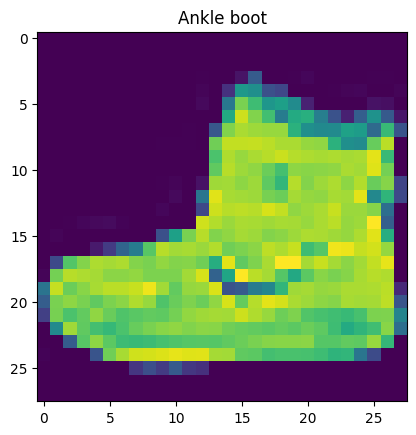

In [121]:
plt.imshow(imgs.squeeze())
plt.title(class_names[label])

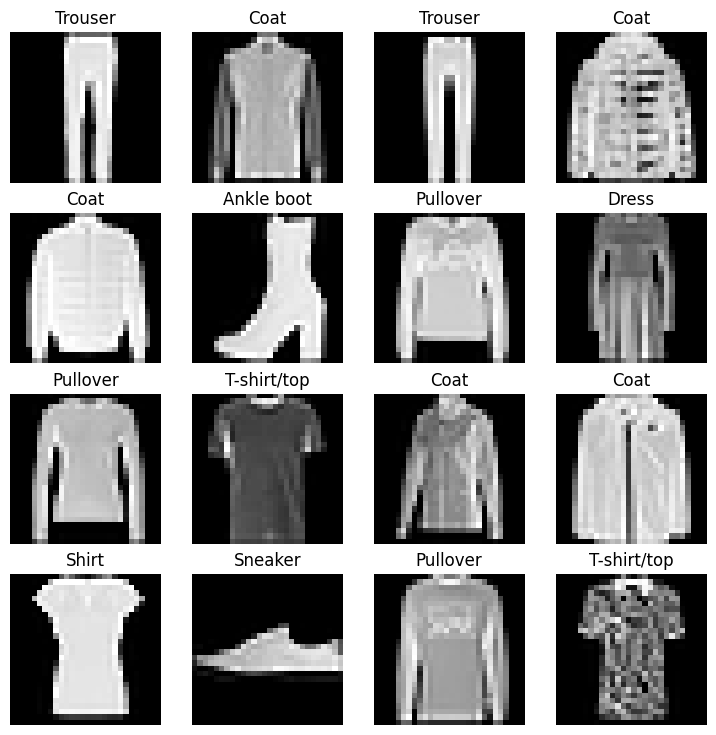

In [122]:
# Let Visualize some plots
rows, cols = 4, 4
fig = plt.figure(figsize=(9,9))
for item in range (1, rows*cols+1):
    randindx = int(torch.randint(0, len(train_data), size=[1]))
    img, labels = train_data[randindx] # type: ignore
    fig.add_subplot(rows, cols, item)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[labels])
    plt.axis(False)

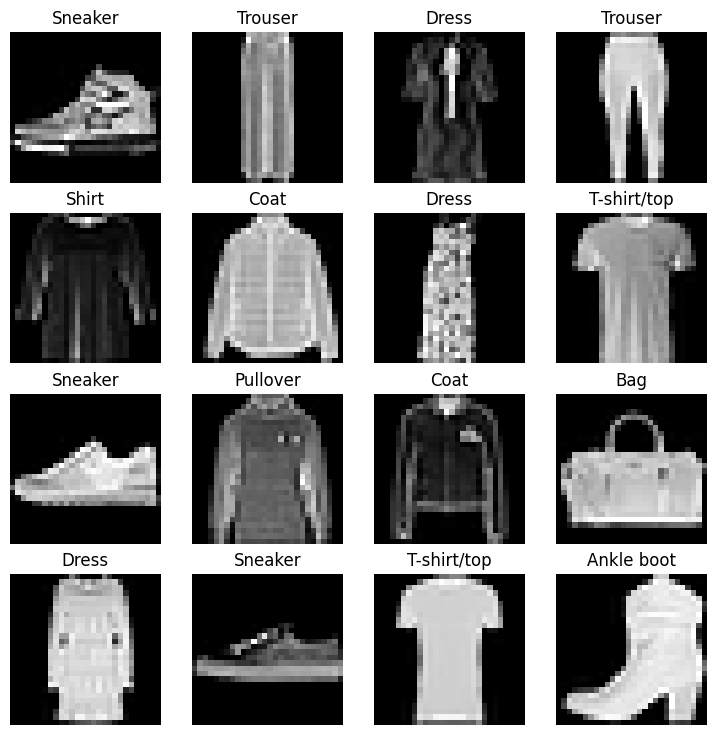

In [123]:
# Let Visualize some plots... a bit differnt approach (vectorized random sampling)

rows, cols = 4, 4
fig = plt.figure(figsize=(9, 9))
randindx = torch.randint(0, len(train_data), size=[rows * cols])

for idx, i in enumerate(randindx, start=1):
    im, l = train_data[int(i)]
    fig.add_subplot(rows, cols, idx)
    plt.imshow(im.squeeze(), cmap="gray")
    plt.title(class_names[l])
    plt.axis(False)


In [124]:
# adding DataLoaders... which turns datasets into iterable batchs

BATCH_SIZE = 32
train_data_loader = DataLoader(
    dataset=train_data,
    batch_size= BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size= BATCH_SIZE,
    shuffle=False
)
train_data_loader,test_data_loader, len(train_data_loader)

(<torch.utils.data.dataloader.DataLoader at 0x1e24b1afe50>,
 1875)

In [125]:
train_data_loader_features, train_data_loader_target = next(iter(train_data_loader))
test_data_loader_features, test_data_loader_target = next(iter(test_data_loader))

train_data_loader_features.shape, train_data_loader_target.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [126]:
# BAselien Model

class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape:int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


In [127]:
model_1 = FashionMNISTModel(input_shape = 784,
                            hidden_units= 10,
                            output_shape=len(class_names))
model_1

FashionMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [128]:
# NOw, Lets setup loss, optimizer, and evalaution metrics(Accuracy)
loss_fn = nn.CrossEntropyLoss()
optizer = torch.optim.SGD(params=model_1.parameters(),
                          lr=0.001)
def accuracy_fun(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [134]:
# Defining Trainign and Test Loops
def traning_loop(model: torch.nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fun: nn.Module,
                 optimizer: torch.optim.Optimizer,
                 accuracy_fun):
    train_loss, train_acc = 0,0

    for batch, (X,y) in enumerate(data_loader):
        # Forward pass
        y_pred = model(X)

        # calulate the Loss
        loss = loss_fun(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fun(y_true=y, y_pred=y_pred.argmax(dim=1)) 
        # Optimizer Zero grad
        optimizer.zero_grad()
        # Loss Backward
        loss.backward()
        # Optimiser Step
        optimizer.step()
    train_loss  /= len(data_loader)
    train_acc /=len(data_loader)
    print(f"Training Loss: {train_loss:.3f} | Training Acc: {train_acc:.3f}")


In [140]:
# Lets continue with the tesing loop
import torch.optim.optimizer


def test_Step(model: nn.Module,
              test_data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fun):
    test_acc, test_loss =0,0
    model.eval()

    # Turn on inference context manager
    with torch.inference_mode():
        for X,y in test_data_loader:
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fun(y_true = y,
                                     y_pred = test_pred.argmax(dim=1))
        test_loss /= len(test_data_loader)
        test_acc /= len(test_data_loader)

        print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.3f}")

In [141]:
# now lets traing for 5 epochs 
epochs = 3
for epoch in range (epochs):
    traning_loop(data_loader=train_data_loader,
                 model=model_1,
                 loss_fun=loss_fn,
                 optimizer=optizer,
                 accuracy_fun=accuracy_fun)
# NOw lets Test /evalaute the data 
    test_Step(model=model_1,
              test_data_loader=test_data_loader,
              loss_fn=loss_fn,
              optimizer=optizer,
              accuracy_fun=accuracy_fun)

Training Loss: 1.316 | Training Acc: 54.862
Test Loss: 1.338 | Test Accuracy: 53.474
Training Loss: 1.312 | Training Acc: 55.008
Test Loss: 1.336 | Test Accuracy: 53.295
Training Loss: 1.308 | Training Acc: 55.132
Test Loss: 1.330 | Test Accuracy: 53.794
